<a href="https://colab.research.google.com/github/MStamirski/Faces/blob/main/Model_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/Colab_Notebooks/SDA_upskill/Faces"

In [ ]:
!pip install import-ipynb

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
import random
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.metrics import Precision
from keras.metrics import Recall
from keras_tuner import Hyperband
from keras_tuner import Objective
import import_ipynb

# Import custom functions

In [ ]:
from Dataset_prep import get_labels, get_faces

In [ ]:
from Functions import plot_history, show_metrics
from Functions import get_best_threshold, get_tuned_prediction, make_prediction

In [ ]:
from Functions_all_labels import prepare_data, show_prediction, show_predictions

# Data for model

In [ ]:
labels = get_labels()
faces, sex, hair, glasses, hat, beard = get_faces(labels, 'photos_dst/')

Processing face nr 1349
Created dataset contains 5300 faces.


In [ ]:
X, y = prepare_data(faces, sex, hair, glasses, hat, beard, ['F', 'L', 'Y', 'Y', 'Y'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=43)

# Model

In [ ]:
def model_builder(hyppar):

  model = Sequential([
    Conv2D(
      filters = hyppar.Int('conv_1_filter', min_value=32, max_value=160, step=16),
      kernel_size = 3, 
      activation = 'relu', 
      input_shape = [64, 64, 1]
    ),
    MaxPooling2D((2, 2)),
    Conv2D(
      filters = hyppar.Int('conv_2_filter', min_value=64, max_value=320, step=32),
      kernel_size = 2, 
      activation = 'relu'
    ),
    MaxPooling2D((2, 2)),
    Conv2D(
      filters = hyppar.Int('conv_3_filter', min_value=128, max_value=640, step=64),
      kernel_size = 2,
      activation = 'relu'
    ),
    Flatten(),
    Dense(
      units = hyppar.Int('dense_units', min_value=256, max_value=1280, step=128),
      activation='relu'
    ),
    Dense(5, activation ='sigmoid')
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(name='precision'), Recall(name='recall')])

  return model

In [ ]:
tuner = Hyperband(hypermodel = model_builder,
                  objective = Objective("val_loss", direction="min"),
                  max_epochs = 20,
					        project_name='hyperband_tuner')

In [ ]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Trial 24 Complete [00h 02m 23s]
val_loss: 0.16859516501426697

Best val_loss So Far: 0.14508342742919922
Total elapsed time: 00h 16m 32s


In [ ]:
best_hyppar = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters")
print(f"Number of filters in 1 convolution layer: {best_hyppar.get('conv_1_filter')}")
print(f"Number of filters in 2 convolution layer: {best_hyppar.get('conv_2_filter')}")
print(f"Number of filters in 3 convolution layer: {best_hyppar.get('conv_3_filter')}")
print(f"Number of units in fully connected layer: {best_hyppar.get('dense_units')}")
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Best hyperparameters
Number of filters in 1 convolution layer: 64
Number of filters in 2 convolution layer: 128
Number of filters in 3 convolution layer: 576
Number of units in fully connected layer: 1152
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                 

In [ ]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape = [64, 64, 1]),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(576, (2, 2), activation='relu'),
    Flatten(),
    Dense(1152, activation='relu'),
    Dense(5, activation ='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(name='precision'), Recall(name='recall')])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
53/53 [==============================] - 14s 56ms/step - loss: 0.4567 - precision: 0.6226 - recall: 0.3986 - val_loss: 0.3714 - val_precision: 0.7172 - val_recall: 0.5946
Epoch 2/20
53/53 [==============================] - 3s 47ms/step - loss: 0.3275 - precision: 0.7927 - recall: 0.5735 - val_loss: 0.2850 - val_precision: 0.7778 - val_recall: 0.6549
Epoch 3/20
53/53 [==============================] - 3s 48ms/step - loss: 0.2452 - precision: 0.8370 - recall: 0.7131 - val_loss: 0.2506 - val_precision: 0.8499 - val_recall: 0.6891
Epoch 4/20
53/53 [==============================] - 3s 49ms/step - loss: 0.1807 - precision: 0.8844 - recall: 0.8025 - val_loss: 0.2049 - val_precision: 0.8295 - val_recall: 0.8028
Epoch 5/20
53/53 [==============================] - 3s 48ms/step - loss: 0.1342 - precision: 0.9114 - recall: 0.8670 - val_loss: 0.1756 - val_precision: 0.8981 - val_recall: 0.7978
Epoch 6/20
53/53 [==============================] - 3s 48ms/step - loss: 0.0947 - precision: 0

# Outcome

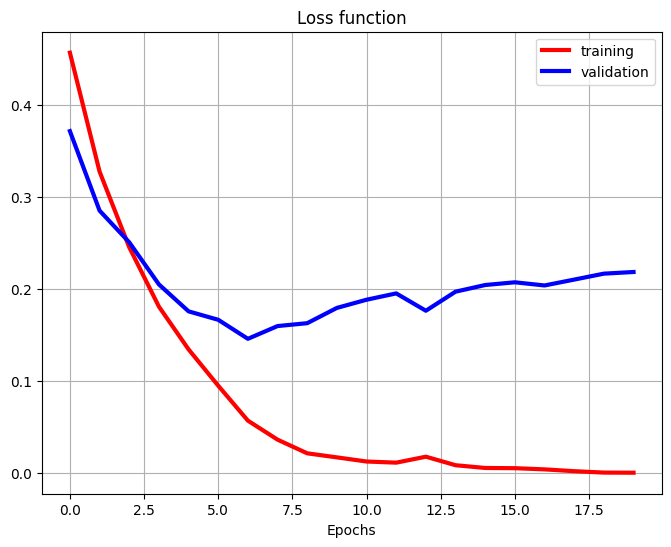

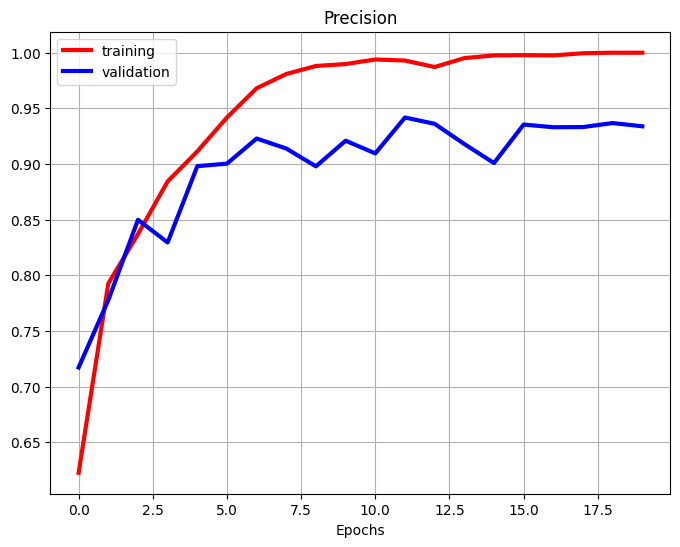

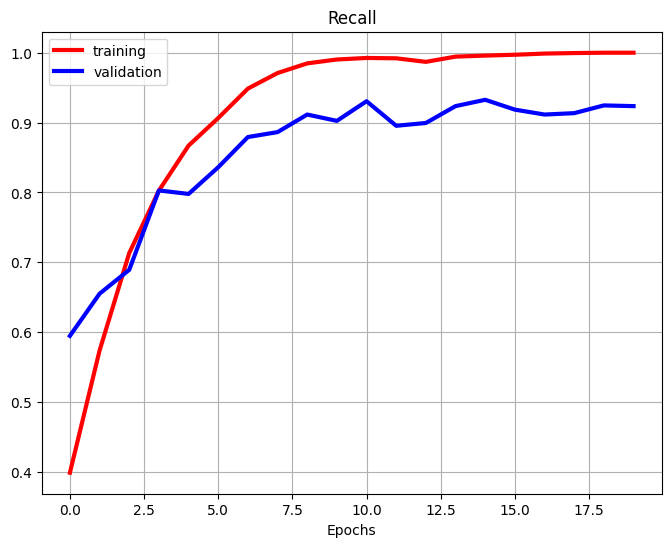

In [ ]:
plot_history(history)

In [ ]:
y_pred_tuned = make_prediction(model, X_test, y_test)

34/34 [==============================] - 15s 413ms/step

Metrics before tuning
Precision: 0.9319999814033508
Recall: 0.925337553024292
F1 Score: 0.9286568760871887

Best threshold: 0.35000000000000003

Metrics after tuning
Precision: 0.9272152185440063
Recall: 0.9308975338935852
F1 Score: 0.9290527105331421




Predictions for label: [Sex] value: [0]



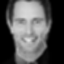


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         0



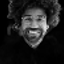


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     1         1



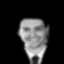


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         0



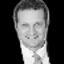


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



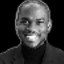


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0


Predictions for label: [Sex] value [1]



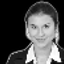


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



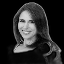


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



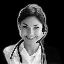


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



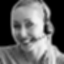


LABELS    VALUES    PREDICTIONS
Sex       1         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         1



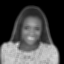


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0


Predictions for label: [Hair] value: [0]



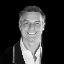


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



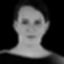


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



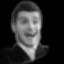


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



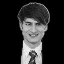


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



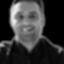


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1


Predictions for label: [Hair] value [1]



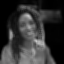


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



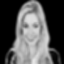


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



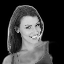


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



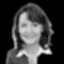


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



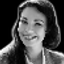


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0


Predictions for label: [Glasses] value: [0]



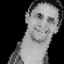


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



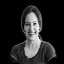


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



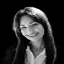


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



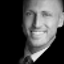


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



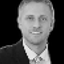


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         1


Predictions for label: [Glasses] value [1]



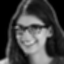


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     0         0



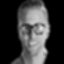


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   1         1
Hat       0         0
Beard     0         0



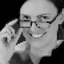


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         0
Glasses   1         1
Hat       0         0
Beard     0         0



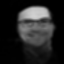


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   1         1
Hat       0         0
Beard     0         0



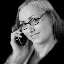


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     0         0


Predictions for label: [Hat] value: [0]



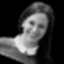


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0



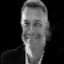


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



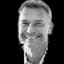


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



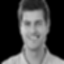


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



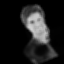


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0


Predictions for label: [Hat] value [1]



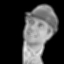


LABELS    VALUES    PREDICTIONS
Sex       0         1
Hair      0         0
Glasses   0         0
Hat       1         0
Beard     0         0



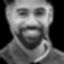


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       1         1
Beard     1         1



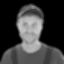


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       1         0
Beard     1         1



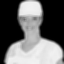


LABELS    VALUES    PREDICTIONS
Sex       1         0
Hair      0         0
Glasses   0         0
Hat       1         0
Beard     0         0



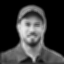


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       1         1
Beard     1         1


Predictions for label: [Beard] value: [0]



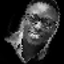


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   1         0
Hat       0         0
Beard     0         0



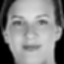


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      0         1
Glasses   0         0
Hat       0         0
Beard     0         0



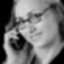


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     0         0



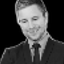


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     0         0



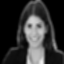


LABELS    VALUES    PREDICTIONS
Sex       1         1
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     0         0


Predictions for label: [Beard] value [1]



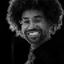


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      1         1
Glasses   0         0
Hat       0         0
Beard     1         1



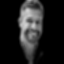


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1



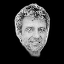


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1



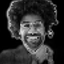


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      1         1
Glasses   1         1
Hat       0         0
Beard     1         1



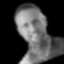


LABELS    VALUES    PREDICTIONS
Sex       0         0
Hair      0         0
Glasses   0         0
Hat       0         0
Beard     1         1


In [ ]:
show_predictions(X_test, y_test, y_pred_tuned)

In [ ]:
model.save("Faces_model")